# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/23 07:03:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/23 07:03:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/02/23 07:03:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/02/23 07:03:11 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Load regions

In [4]:
indy = Region.load('Indianapolis', 'Indiana')

In [5]:
aus = Region.load('Austin', 'Texas')

In [6]:
hous = Region.load('Houston', 'Texas')

In [7]:
rgns = [indy, aus, hous]

In [8]:
for rgn in rgns:
    rgn.boundary = gpd.read_file(rgn.geom / 'city_limit.gpkg')

## Load nighttime data

In [9]:
indy.night_pings = SP.read_parquet(indy.data / 'night_pings').disp()

+--------------------+---+--------------------+--------------------+--------------------+
|                 uid|day|                 lon|                 lat|                slot|
+--------------------+---+--------------------+--------------------+--------------------+
|-9219177883694077236|  1|[-86.0029, -86.00...|[39.96386, 39.963...|[7, 7, 7, 7, 7, 7...|
+--------------------+---+--------------------+--------------------+--------------------+
only showing top 1 row



In [10]:
aus.night_pings = SP.read_parquet(aus.data / 'night_pings')

In [11]:
hous.night_pings = SP.read_parquet(hous.data / 'night_pings')

# Prepare home locations

## $A_0$: Simple centroid
Home location is the centroid of the all-time nighttime data.

In [12]:
P.params.set({'algorithms': {'A0': {
    'name': 'Simple centroid',
    'description': 'Home location is the centroid of the all-time nighttime data.'
}}})

In [13]:
def get_homes_a0(rgn, save=False):
    df = rgn.night_pings.groupby(UID).agg(*[
        F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    df = df.select(UID, *[F.udf(lambda x: sum(x)/len(x), T.float)(x).alias(x) 
                          for x in [LON, LAT]])
    if save:
        outpath = U.mkdir(rgn.data / 'home_locs') / 'A0.parquet'
        df = df.toPandas().to_parquet(outpath)
    return df

In [14]:
pd.read_parquet(indy.data / 'home_locs/A0.parquet').disp(0); pass

108,540 rows x 3 cols; Memory: 1.7 MiB


uid        lon        lat
  <int64>  <float32>  <float32>

## $A_1$: All-time clustering
Home location is the center of the largest cluster of all-time nighttime data.

In [15]:
# import json
# from pqdm.processes import pqdm
from sklearn.cluster import MeanShift

### Parameters

In [16]:
cluster_radius = 500 # meters
# parameters for MeanShift clustering
ms_params = dict(
    bin_seeding = True,
    min_bin_freq = 5,
    max_iter = 30,
    cluster_all = False
)

In [17]:
P.params.set({'algorithms': {'A1': {
    'name': 'All-time clustering',
    'description': 'Home location is the center of the largest cluster of all-time nighttime data based on MeanShift clustering.',
    'meanshift': {'clustering_radius': cluster_radius} | ms_params
}}})

### Define method

In [18]:
def meanshift_single(x, y, bw: float, kwargs=ms_params):
    try:
        model = MeanShift(bandwidth=bw, **kwargs)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model.fit(np.vstack([x, y]).T)
        return model.cluster_centers_[0].tolist()
    except ValueError:
        return [np.nan, np.nan]

In [19]:
def get_homes_a1(rgn, radius=cluster_radius, ms_params=ms_params):
    df = rgn.night_pings.groupby(UID).agg(*[
        F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    df = df.toPandas()
    res = []
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        bandwidth = mk.geo.dist_m2deg(radius, np.mean(r[LAT]))
        res.append([r[UID]] + meanshift_single(r[LON], r[LAT], bandwidth))
    res = Pdf(res, columns=[UID, LON, LAT]).dropna()
    res.to_parquet(U.mkdir(rgn.data / 'home_locs') / 'A1.parquet')
    return res
    
# %time x1 = get_homes_a1(indy); x1

### Run method

## $A_2$: Superping clustering
For each ½-hour slot, the pings are aggregated to just the mean "super-ping". If `max_rg` is supplied, only superpings with radius of gyration smaller than this amount are filtered. The created/filtered superpings are finally clustered and the largest cluster center is chosen as the home location.

In [20]:
P.params.set({'algorithms': {'A2': {
    'name': 'All-time clustering',
    'description': 'For each ½-hour slot, the pings are aggregated to just the mean “super-ping“. The created/filtered superpings are finally clustered and the largest cluster center is chosen as the home location.',
    'meanshift': {'clustering_radius': cluster_radius} | ms_params
}}})

In [21]:
def get_homes_a2(rgn, radius=cluster_radius, max_rg=None, process=True):
    df = SP.read_parquet(rgn.data / 'night_superpings')
    if type(max_rg) in [int, float]:
        df = df.filter(f'rg <= {max_rg}')
        P.params.set('algorithms.A2b', dict(
            name='Superping clustering with max rg',
            description='Same as A2 but with a maximum limit on radius of gyration of each superping.',
            max_rg=max_rg))
    if not process: return
    df = df.groupby(UID).agg(*[F.collect_list('mean_'+x).alias(x) for x in [LON, LAT]])
    df = df.toPandas()
    res = []
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        bandwidth = mk.geo.dist_m2deg(radius, np.mean(r[LAT]))
        res.append([r[UID]] + meanshift_single(r[LON], r[LAT], bandwidth))
    res = Pdf(res, columns=[UID, LON, LAT]).dropna()
    fname = 'A2' if max_rg is None else 'A2b'
    res.to_parquet(rgn.data / f'home_locs/{fname}.parquet')
    return res
    
x2 = get_homes_a2(indy, process=False); x2

### Without any $r_g$ filter

### With $r_g$ filter

# Visualize

## Home locations

In [22]:
algos = ['A0', 'A1', 'A2']

In [23]:
summary = []
for rgn in rgns:
    for alg in algos:
        try:
            df = pd.read_parquet(rgn.data / f'home_locs/{alg}.parquet')
            setattr(rgn, 'h' + alg, df)
            summary.append(dict(algorithm=f'A{alg}', city=rgn.name, n_users=df.shape[0]))
        except Exception as e:
            print(rgn, alg, e)
Pdf(summary).pivot(index='algorithm', columns='city', values='n_users')

city       Austin  Houston  Indianapolis
algorithm                               
AA0         44005   431713        108540
AA1         43860   147183         63264
AA2         41520   139049         63040

In [24]:
'Area: {:.1f} sq.km.'.format(indy.cnty.query('name=="Marion"').to_crs(CRS_M).area.iloc[0] / 1e6)

'Area: 1769.6 sq.km.'

In [25]:
import contextily as ctx

In [26]:
def plot_home_locs(rgn, homes_var, grid_size=500, vmax=None,
                   size=(12, 12), dpi=120, markersize=20, cmap='Reds'):
    """
    grid_size: float
        Size of the grid cell (meters)
    """
    h = getattr(rgn, 'h' + homes_var).copy()
    h = mk.geo.pdf2gdf(h, LON, LAT, CRS_DEG).to_crs(CRS_M)
    h = pd.concat([h, mk.geo.gdf2pdf(h, 'x', 'y', CRS_M)], axis=1).dropna()
    for x in ['x', 'y']:
        h[x] = (h[x] / grid_size).astype(int) * grid_size
    h = h.groupby(['x', 'y']).size().rename('n_users').reset_index()
    h = mk.geo.pdf2gdf(h, 'x', 'y', CRS_M)
    minx, miny, maxx, maxy = rgn.cnty.to_crs(CRS_M).unary_union.bounds
    ax = U.plot(size=size, dpi=dpi, xeng=1, yeng=1, title=f'Method: {homes_var}',
                # xlim=(minx, maxx), ylim=(miny, maxy),
                xlab='Distance from westernmost edge (km)',
                ylab='Distance from southernnmost edge (km)')
    boundary = rgn.boundary.to_crs(CRS_M)
    h = gpd.sjoin(h, boundary, predicate='within')
    h.plot(ax=ax, column='n_users', cmap=cmap, markersize=markersize,
           legend=True, alpha=0.5, vmax=vmax, zorder=100, marker='s', edgecolor='none',
           legend_kwds=dict(shrink=0.5, label='No. of users'))
    boundary.plot(ax=ax, edgecolor='b', facecolor='none', linewidth=2)
    # rgn.cnty.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k',
    #                             linewidth=2, zorder=101)
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite, crs=CRS_M)
    # xticks = Arr([y._x for y in ax.get_xticklabels()])
    # yticks = Arr([y._y for y in ax.get_yticklabels()])
    # fmt = mpl.ticker.EngFormatter()
    # xlabs = [fmt.format_eng(x) for x in (xticks - xticks.min())/1000]
    # ylabs = [fmt.format_eng(y) for y in (yticks - yticks.min())/1000]
    # ax.set_xticks(xticks, xlabs)
    # ax.set_yticks(yticks, ylabs)
    # plt.axis('equal')

CPU times: user 5.67 s, sys: 4.96 s, total: 10.6 s
Wall time: 4.65 s


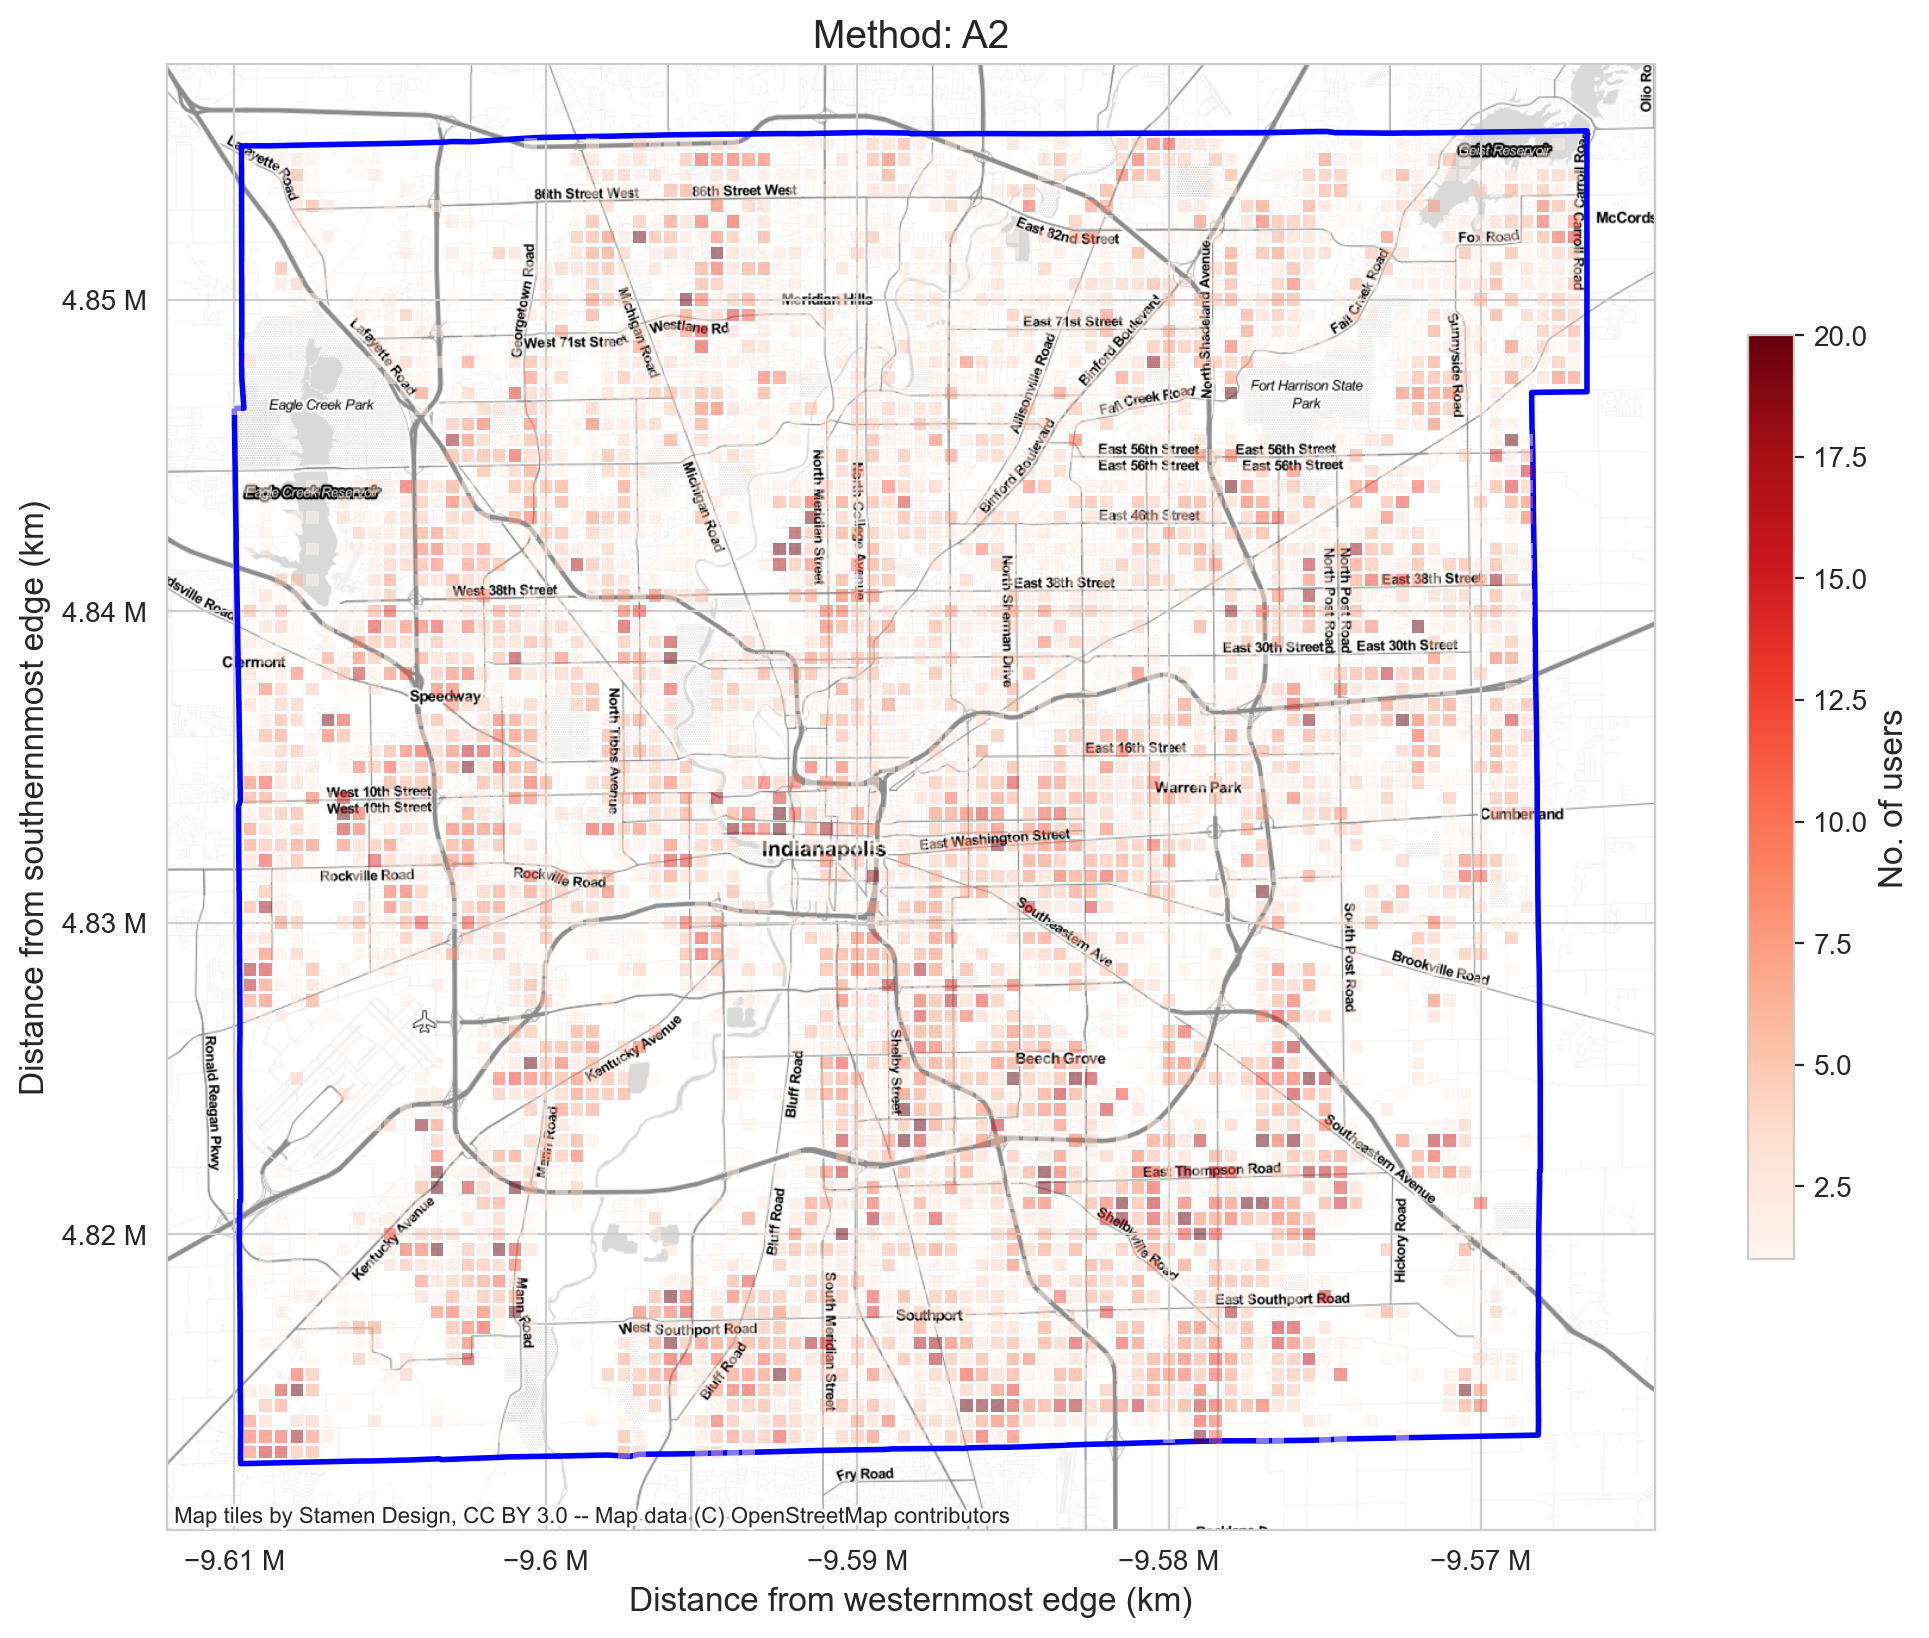

In [27]:
%time plot_home_locs(indy, 'A2', vmax=20, dpi=200) # t=2s

CPU times: user 1.63 s, sys: 199 ms, total: 1.82 s
Wall time: 1.51 s


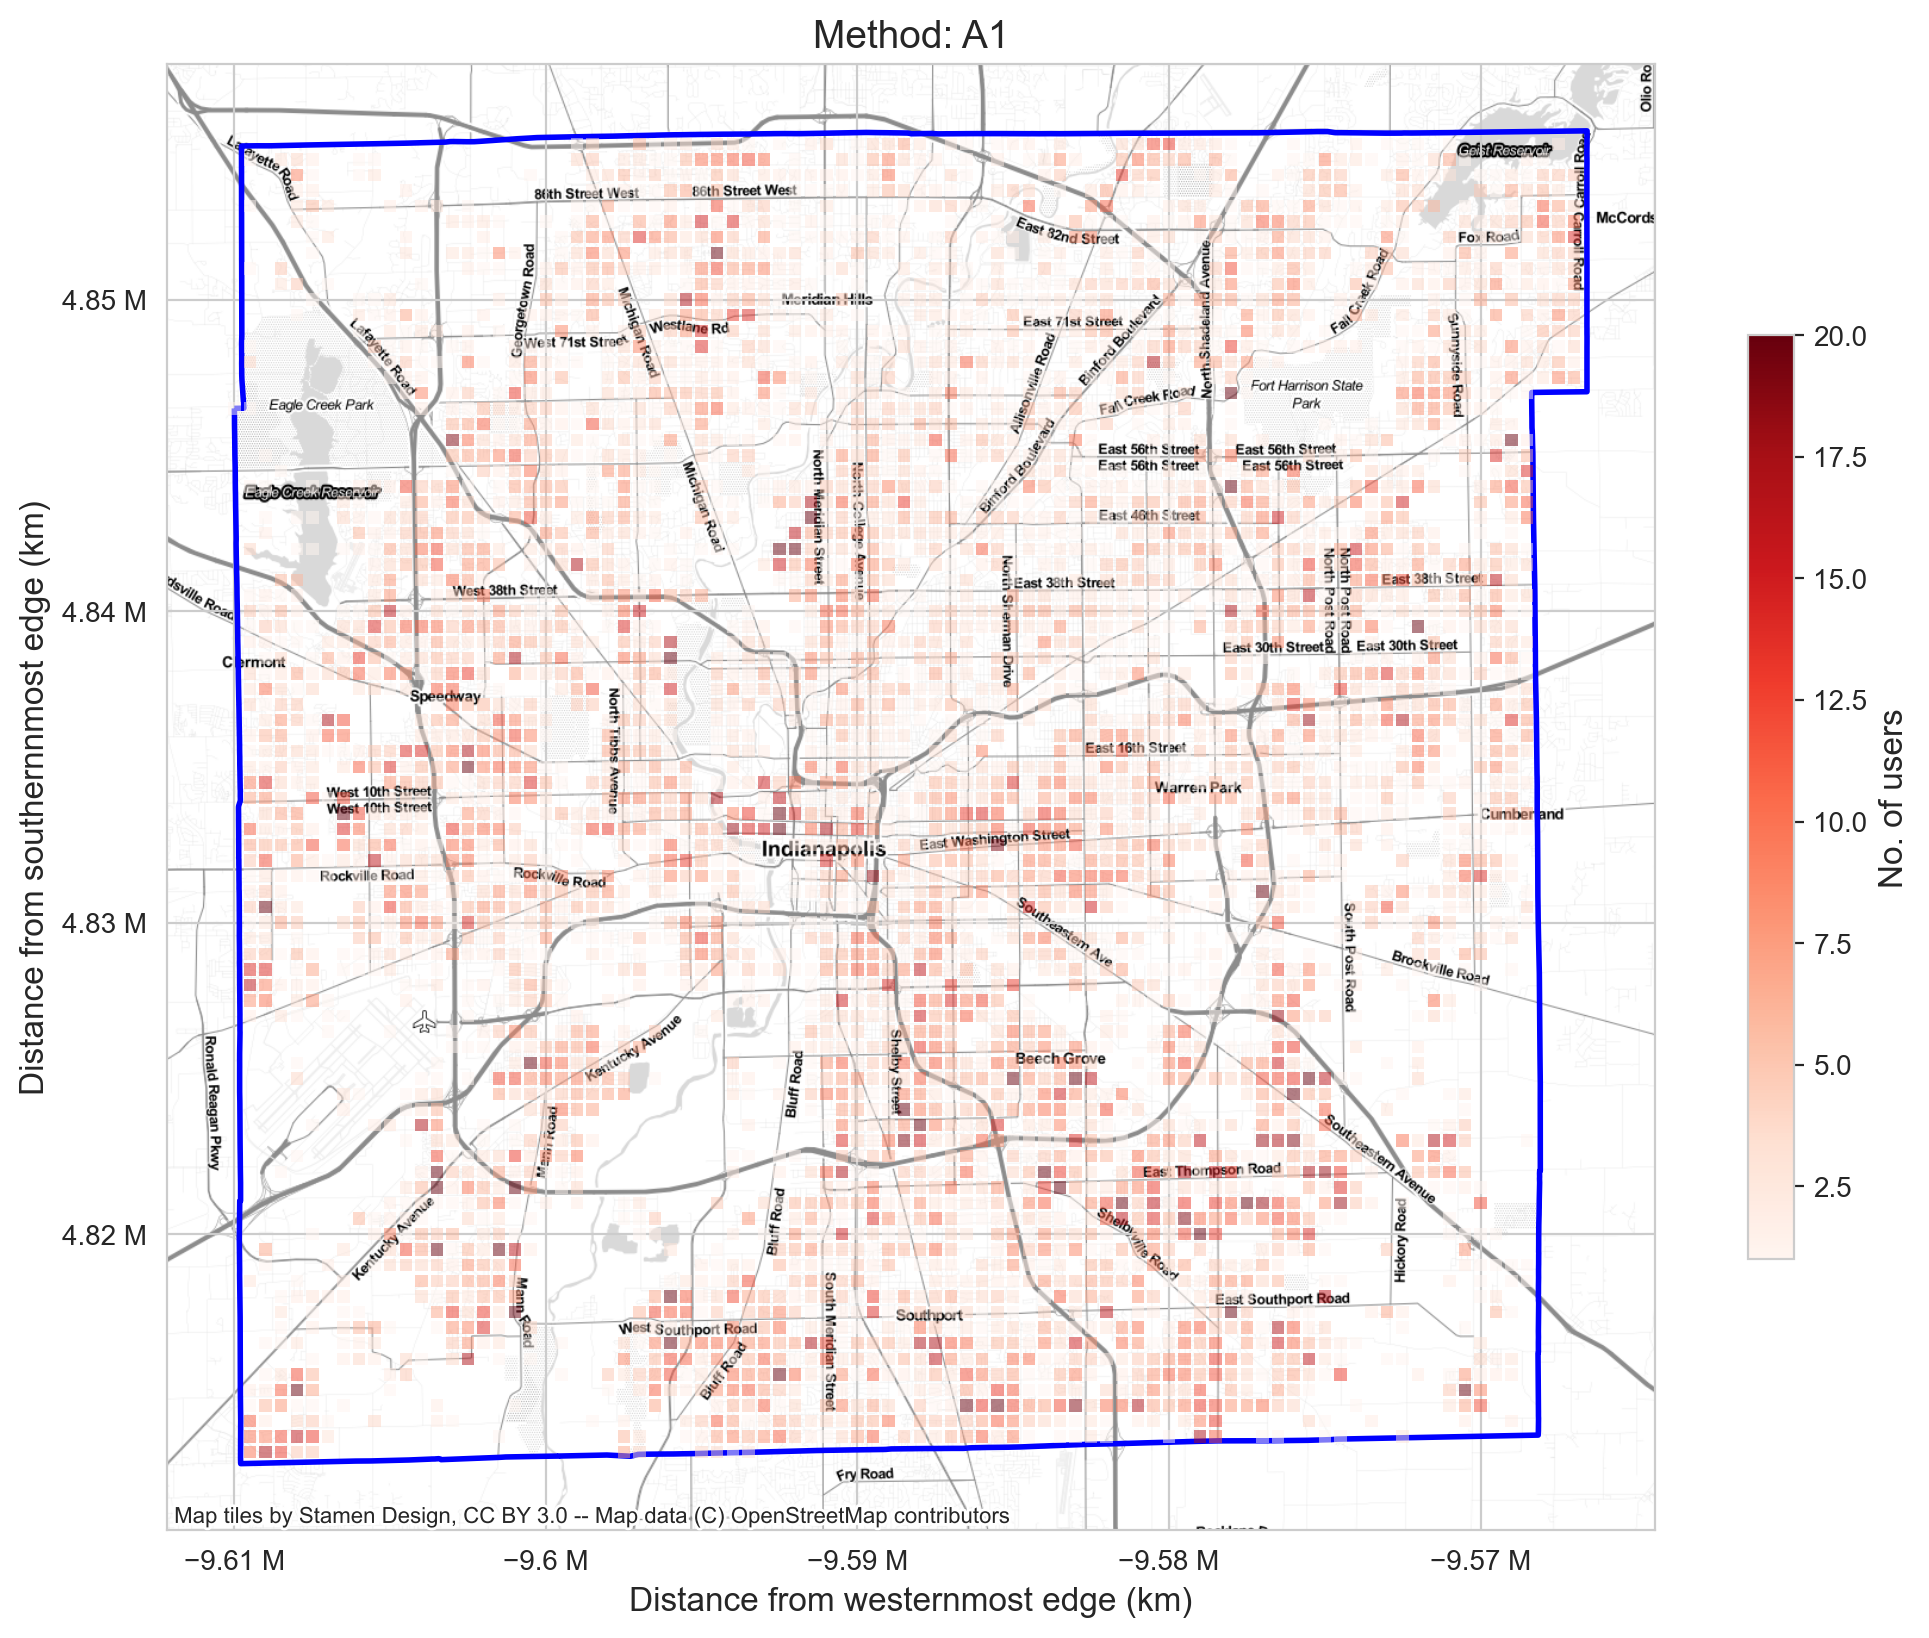

In [28]:
%time plot_home_locs(indy, 'A1', vmax=20, dpi=200) # t=2s

CPU times: user 1.82 s, sys: 179 ms, total: 2 s
Wall time: 2.5 s


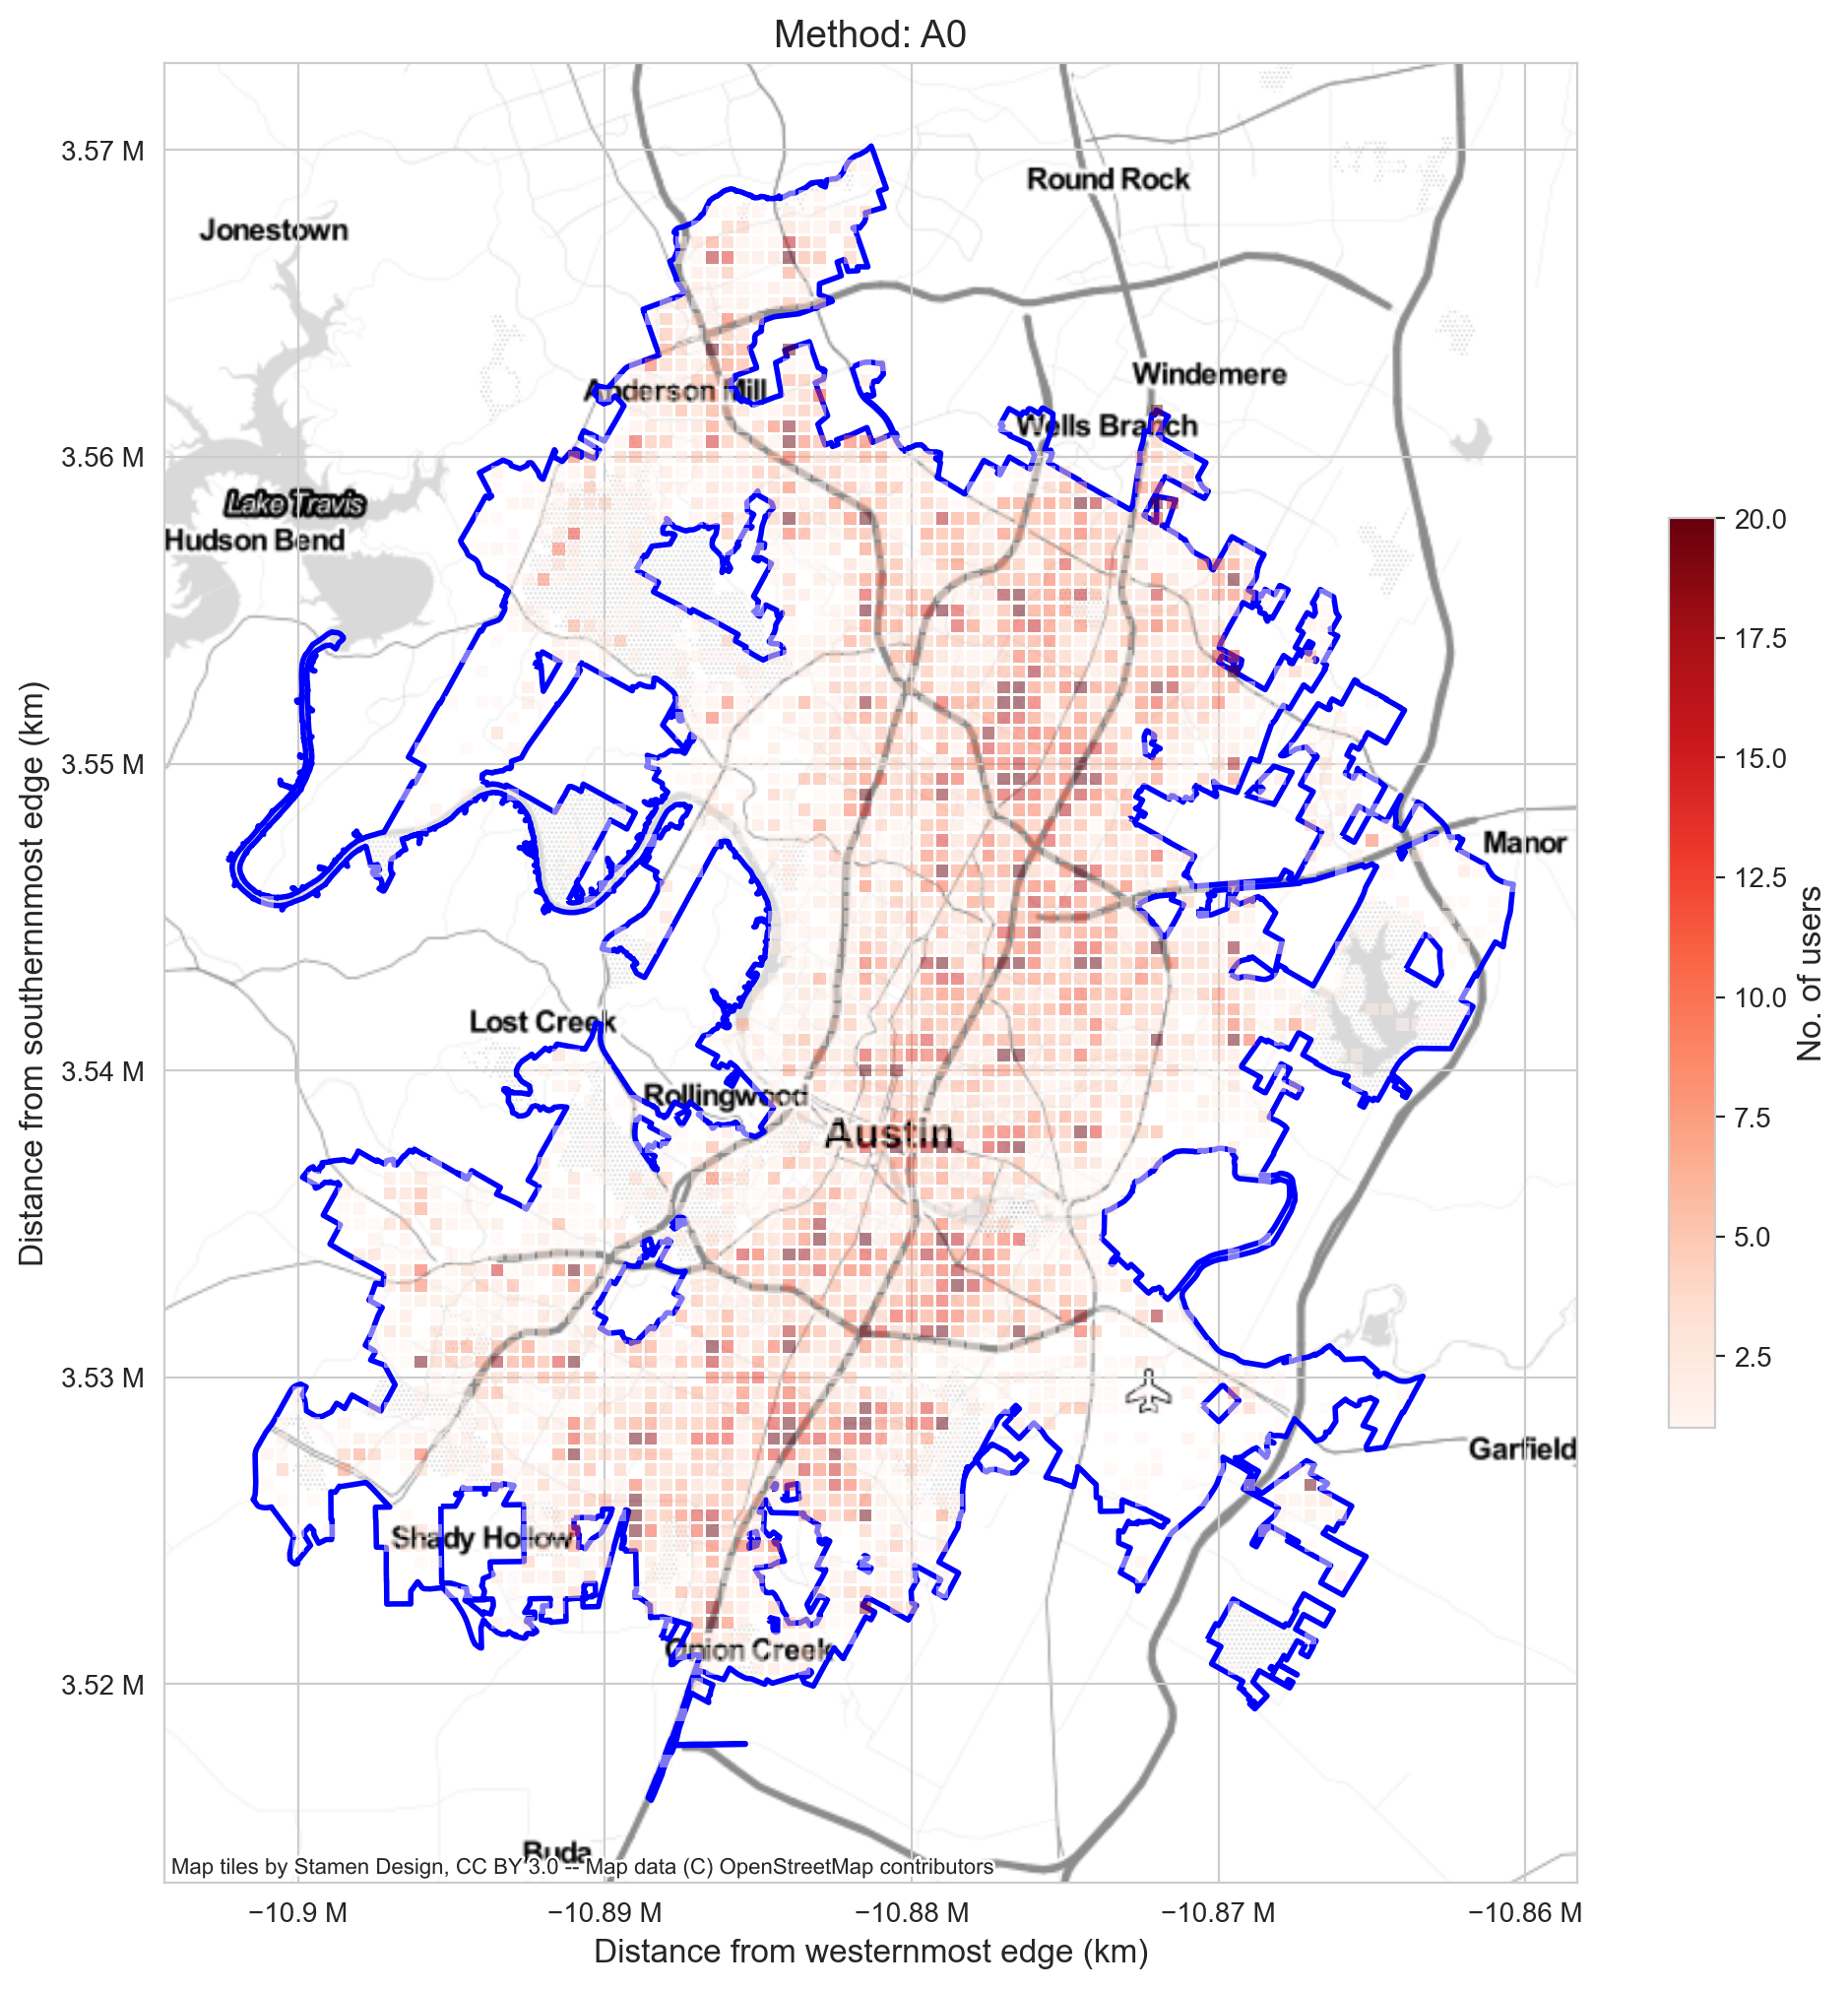

In [29]:
%time plot_home_locs(aus, 'A0', vmax=20, dpi=200) # t=2s

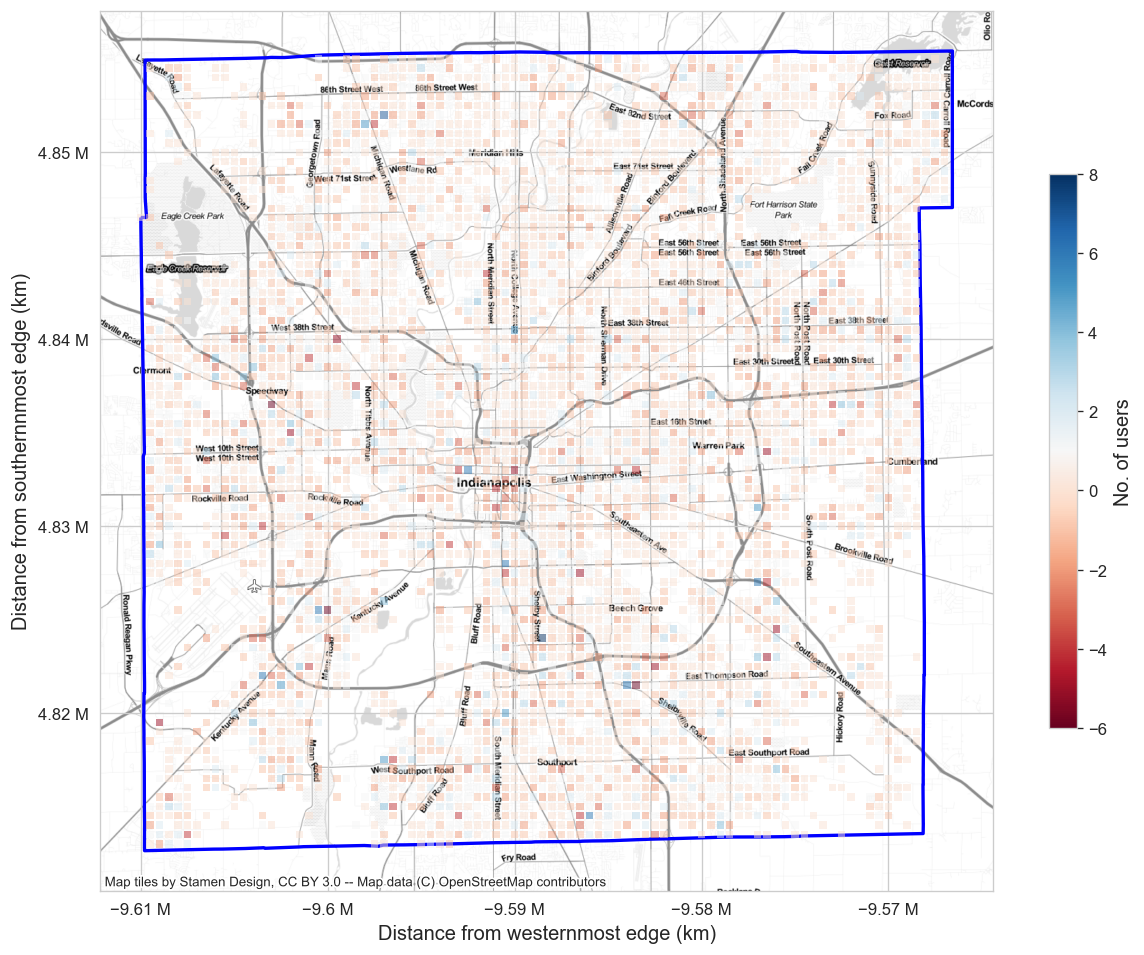

In [30]:
def plot_home_locs_diff(rgn, grid_size=500, vmin=None, vmax=None,
                   size=(12, 12), dpi=120, markersize=20, cmap='RdBu'):
    """
    grid_size: float
        Size of the grid cell (meters)
    """
    hold = getattr(rgn, 'hA1').copy()
    hnew = getattr(rgn, 'hA2').copy()
    hold = mk.geo.pdf2gdf(hold, LON, LAT, CRS_DEG).to_crs(CRS_M)
    hnew = mk.geo.pdf2gdf(hnew, LON, LAT, CRS_DEG).to_crs(CRS_M) 
    hold = pd.concat([hold, mk.geo.gdf2pdf(hold, 'x', 'y', CRS_M)], axis=1).dropna()
    hnew = pd.concat([hnew, mk.geo.gdf2pdf(hnew, 'x', 'y', CRS_M)], axis=1).dropna()
    for x in ['x', 'y']:
        hold[x] = (hold[x] / grid_size).astype(int) * grid_size
        hnew[x] = (hnew[x] / grid_size).astype(int) * grid_size
    hold = hold.groupby(['x', 'y']).size().rename('n_old').fillna(0)
    hnew = hnew.groupby(['x', 'y']).size().rename('n_new').fillna(0)
    h = pd.concat([hold, hnew], axis=1).fillna(0).reset_index()
    h['delta'] = h['n_new'] - h['n_old']
    h = mk.geo.pdf2gdf(h, 'x', 'y', CRS_M)
    minx, miny, maxx, maxy = rgn.cnty.to_crs(CRS_M).unary_union.bounds
    ax = U.plot(size=size, dpi=dpi, xeng=1, yeng=1,
                # xlim=(minx, maxx), ylim=(miny, maxy),
                xlab='Distance from westernmost edge (km)',
                ylab='Distance from southernnmost edge (km)')
    boundary = rgn.boundary.to_crs(CRS_M)
    h = gpd.sjoin(h, boundary, predicate='within')
    h.plot(ax=ax, column='delta', cmap=cmap, markersize=markersize,
           legend=True, alpha=0.5, vmin=vmin, vmax=vmax, zorder=100, marker='s', edgecolor='none',
           legend_kwds=dict(shrink=0.5, label='No. of users'))
    boundary.plot(ax=ax, edgecolor='b', facecolor='none', linewidth=2)
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite, crs=CRS_M)
    
plot_home_locs_diff(indy)

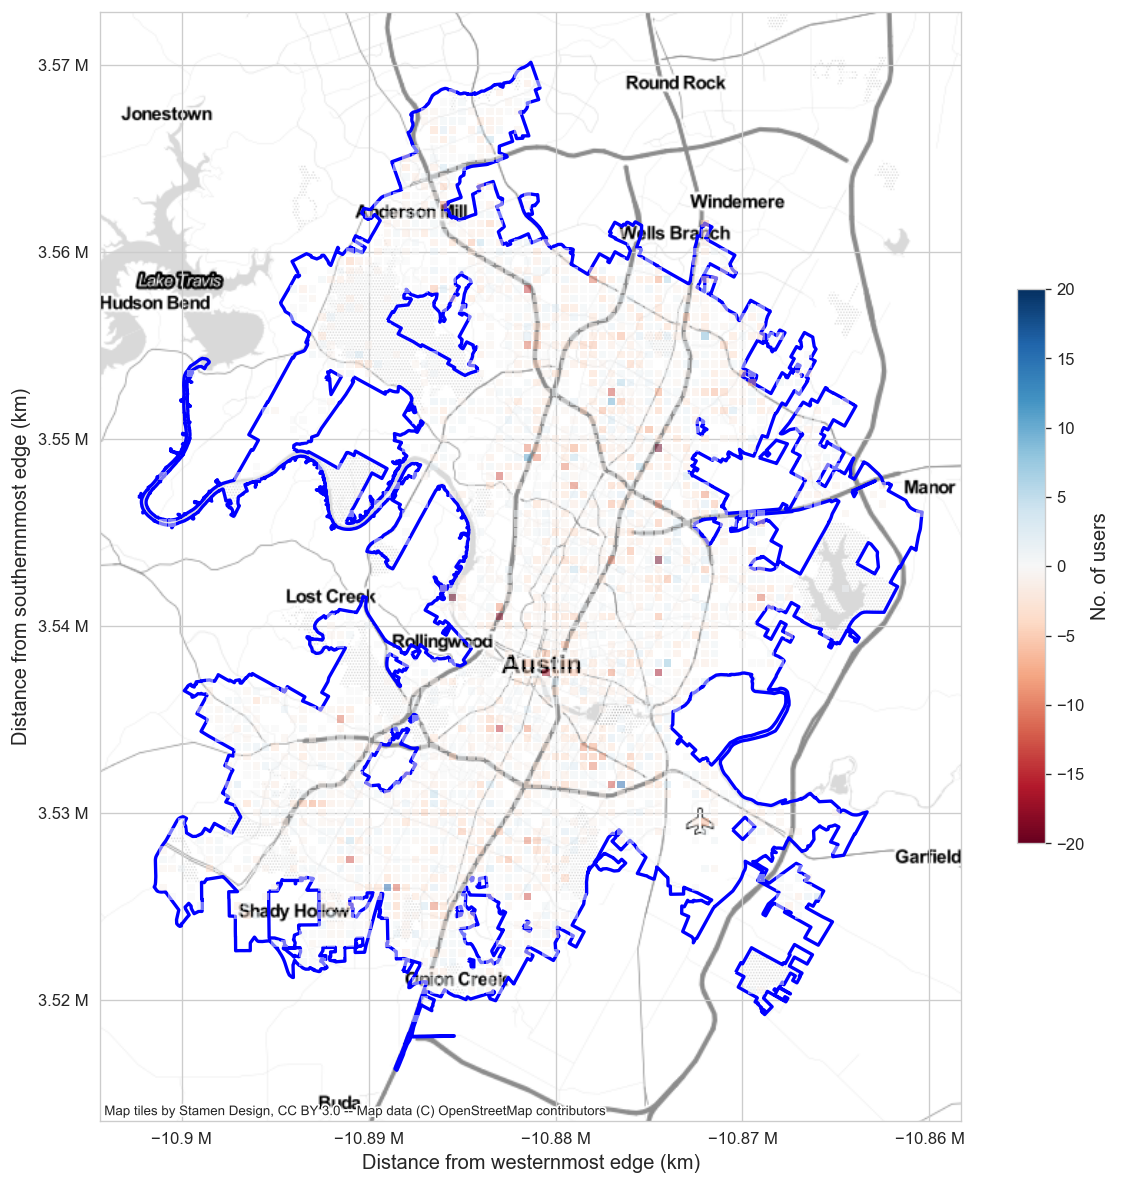

In [31]:
plot_home_locs_diff(aus, vmin=-20, vmax=20)

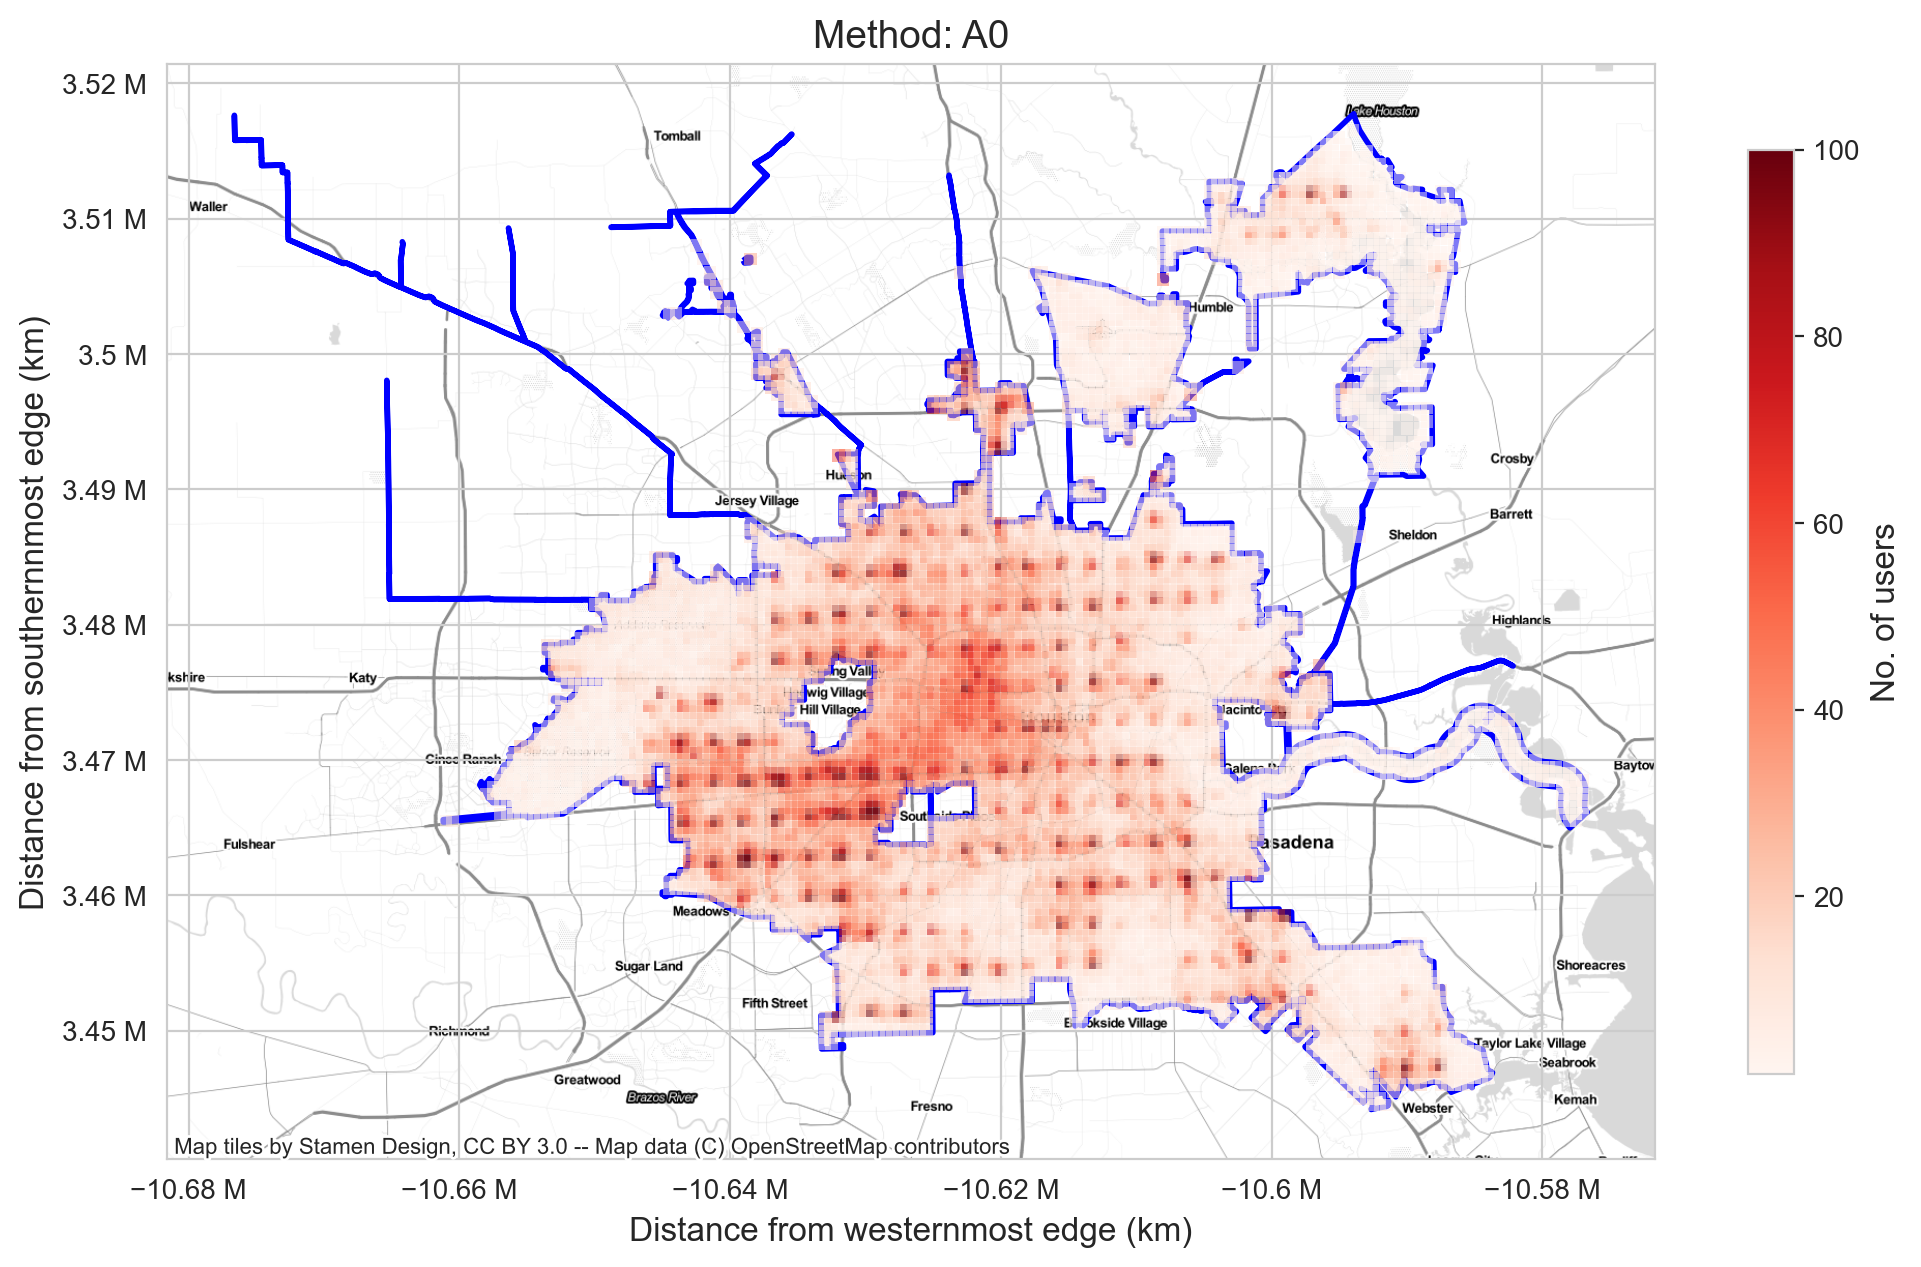

In [32]:
plot_home_locs(hous, 'A0', vmax=100, dpi=200)

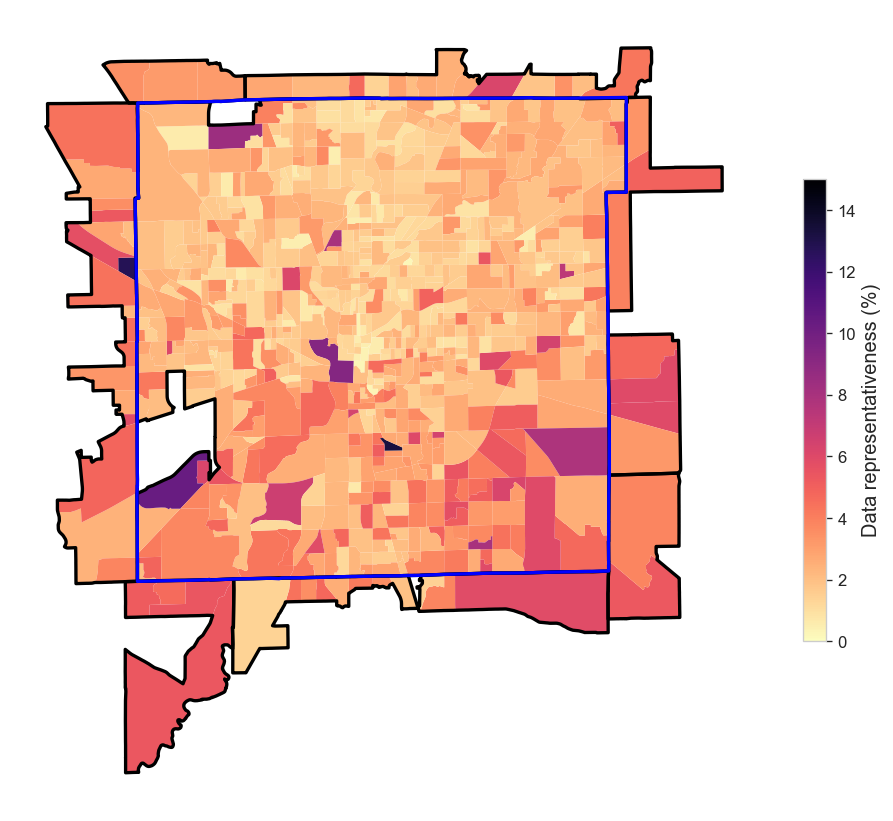

In [33]:
def plot_representativeness_cbg(rgn, homes_var, vmin=0, vmax=15,
                                size=(10, 10), dpi=120, cmap='magma_r'):
    homes = getattr(rgn, 'h' + homes_var).copy()
    homes = mk.geo.pdf2gdf(homes, LON, LAT, CRS_DEG)
    acs = gpd.read_file(rgn.data / f'geometry/acs.gpkg').query('popu > 0')
    homes = gpd.sjoin(homes, acs[['geometry', 'geoid']], predicate='within')
    n_users = homes.groupby('geoid').size().rename('n_users').reset_index()
    acs = acs.merge(n_users, on='geoid')[['county', 'n_users', 'popu', 'geometry']]
    acs['repres'] = (acs['n_users'] * 100) / acs['popu']
    ax = U.plot(size=size, dpi=dpi, axoff=1)
    acs = gpd.sjoin(acs, rgn.boundary)
    acs.to_crs(CRS_M).plot(
        ax=ax, column='repres', cmap=cmap, legend=True, 
        vmin=vmin, vmax=vmax, edgecolor='none', # classification_kwds=dict(bins=np.arange(vmin, vmax+1)),
        legend_kwds=dict(shrink=0.5, label='Data representativeness (%)'))
    counties = acs.groupby('county')['geometry'].agg(lambda x: x.unary_union).set_crs(CRS_DEG)
    counties.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
    rgn.boundary.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='b', linewidth=2)

plot_representativeness_cbg(indy, 'A2')

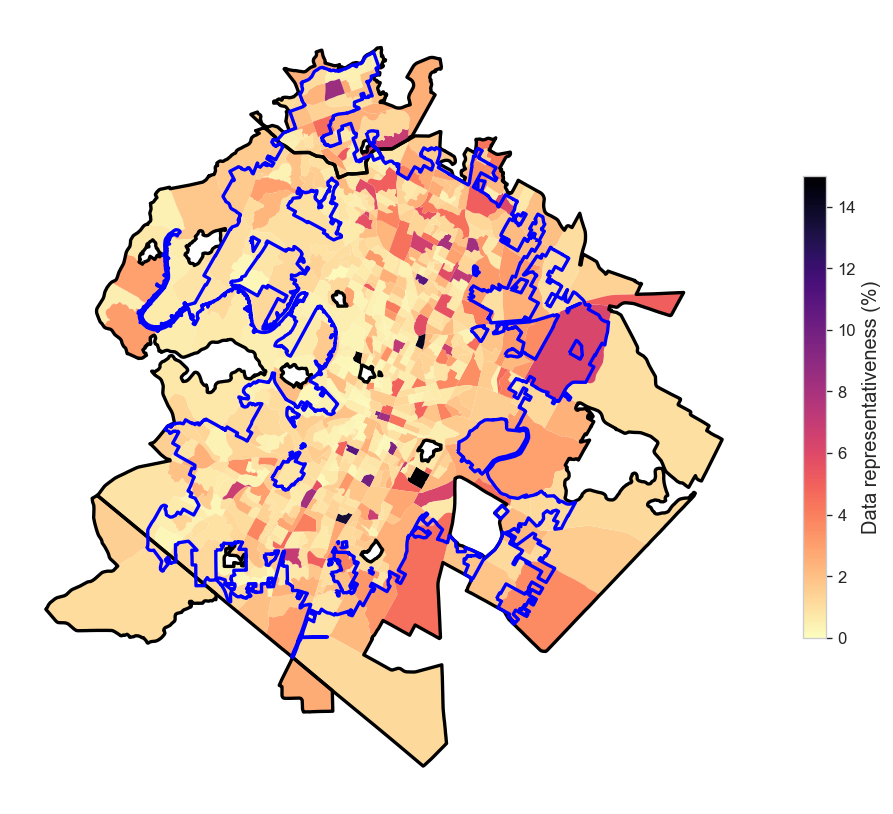

In [34]:
plot_representativeness_cbg(aus, 'A2')